In [ ]:
# to copy a file to the machine :
#obtained from the requirements like the huge picture below,
(base) amr@amr:/home$ sudo scp -i amr/AbasAmrou-m55/ssh-keys/um55_id_rsa /home/amr/all_pdbs.txt  um55@m55.lsb.biocomp.unibo.it:/home/um55



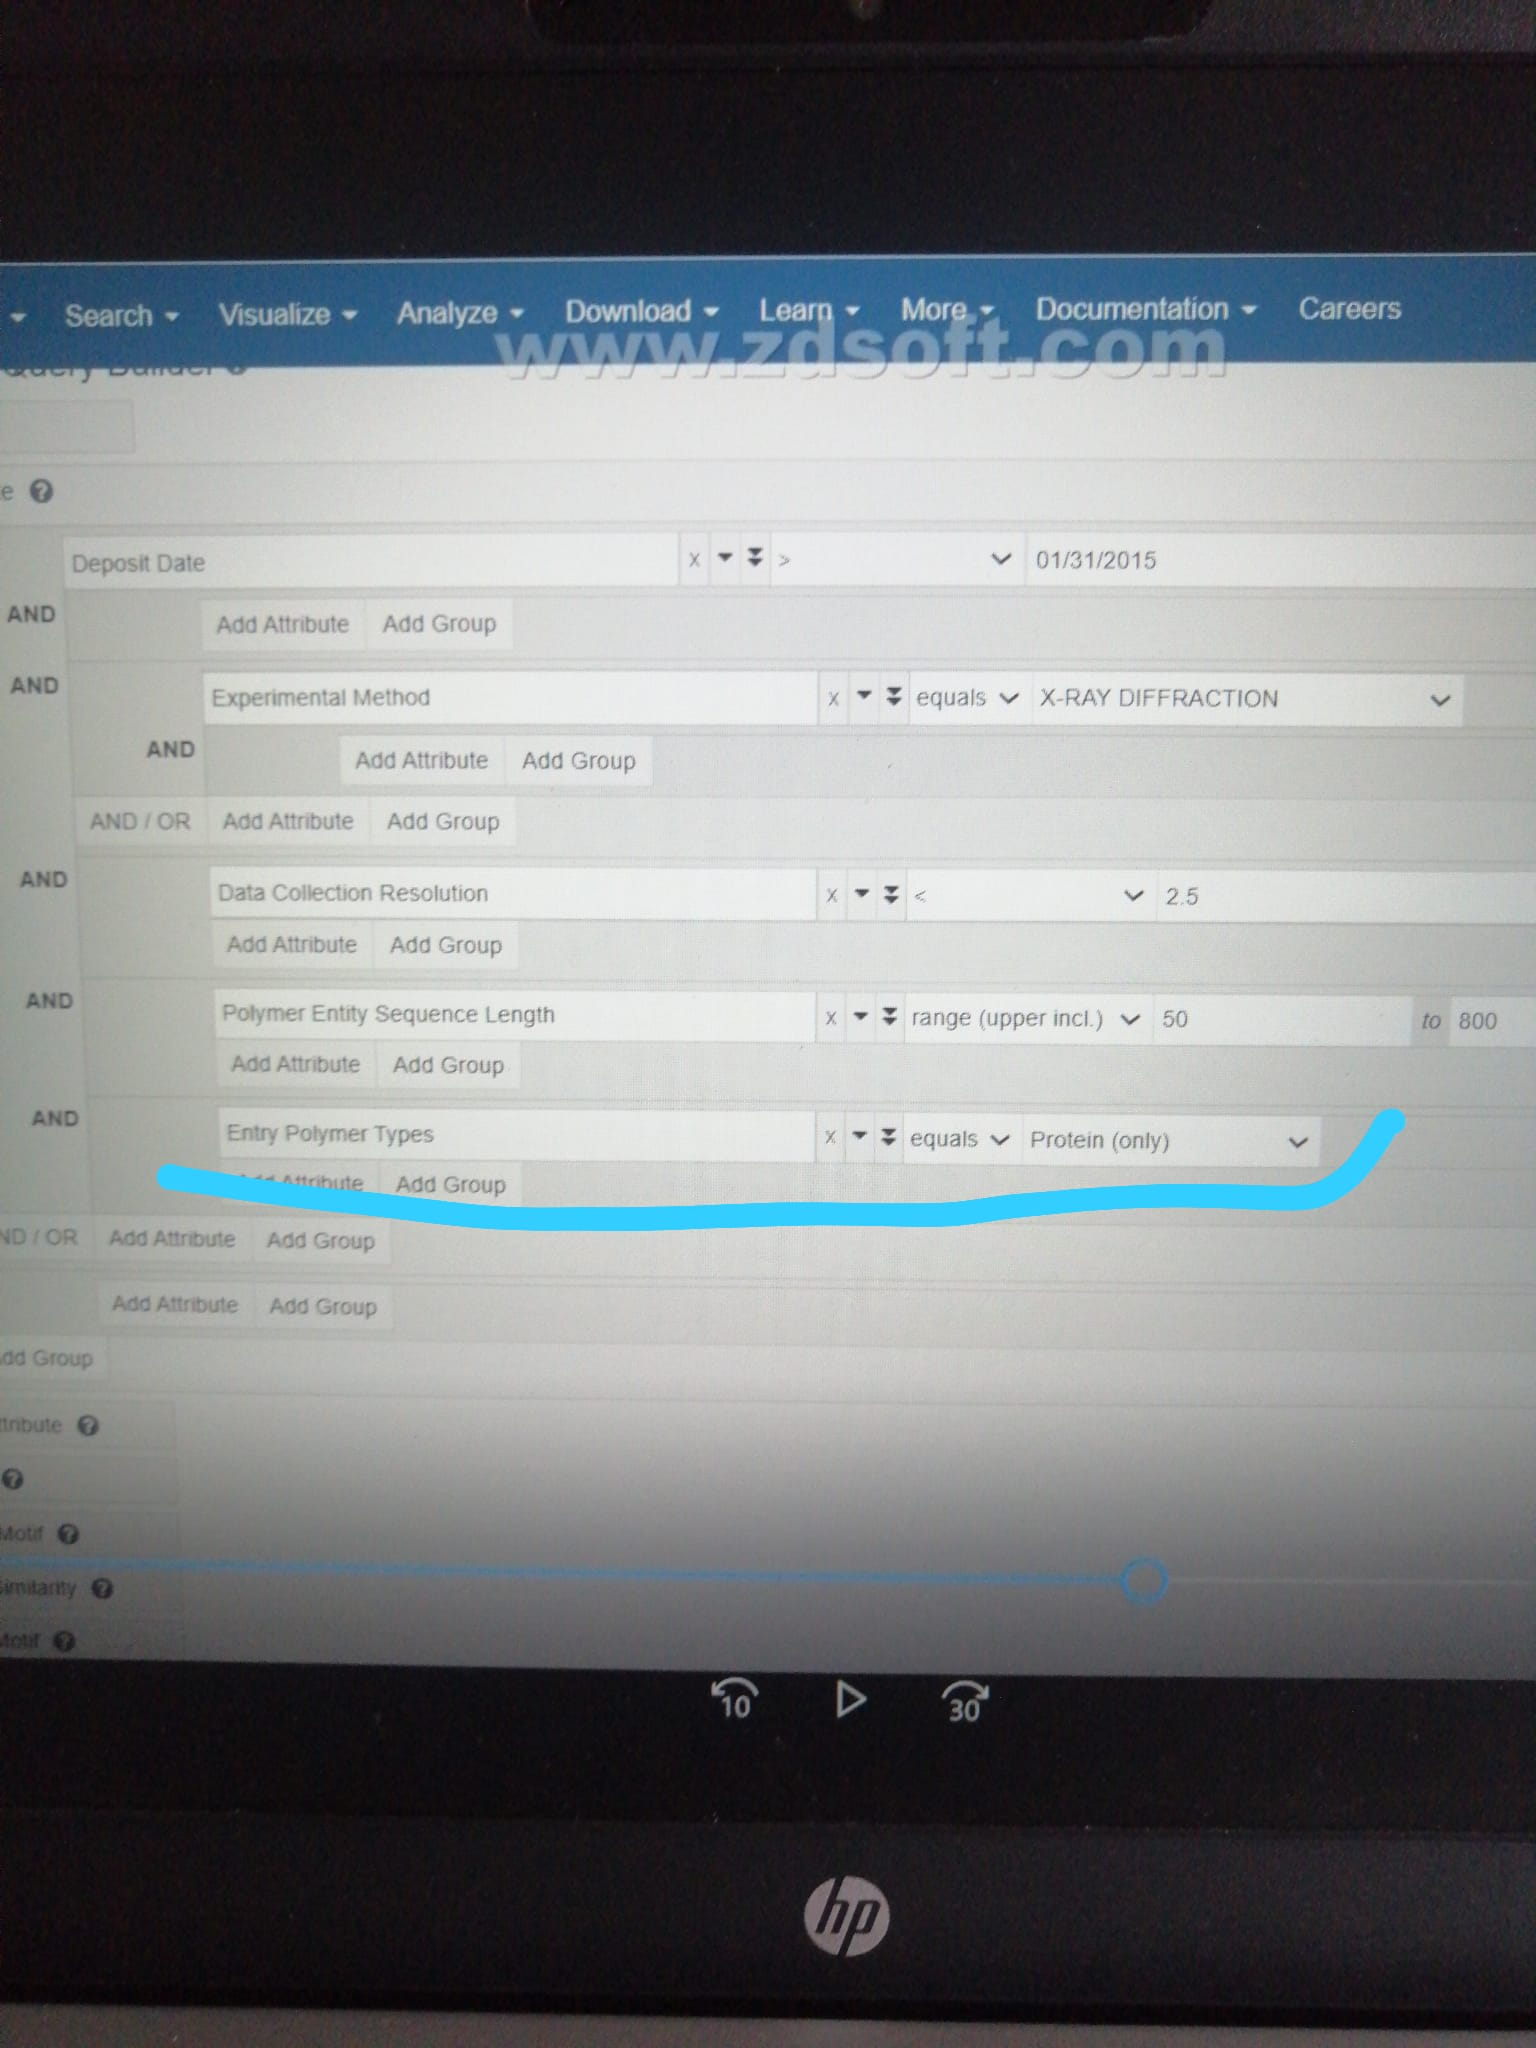

In [ ]:
# to make it multiline instead of comma-separated


sed 's/,/\n/g' all_pdbs.txt > all_pdbs2.txt

#retrieve thier fastas:
um55@m55:~$ for i in $(sed -e 's/,/ /g'  all_pdbs.txt); do curl https://www.rcsb.org/fasta/entry/$i/display >>pdb-fastas.txt; done
um55@m55:~$ for i in `cat all_pdbs2.txt`; do curl (or wget) https://www.rcsb.org/fasta/entry/$i/display >>pdb-fastas.txt; done
um55@m55:~$ for i in `cat all_pdbs2.txt`; do curl https://www.rcsb.org/fasta/entry/$i/display >>pdb-fastas.txt; done



# to get only sequences between 50 and 800:
awk '!/^>/ {next}; {getline s}; length(s) > 50 && length(s) <= 800 { print $0 "\n" s }' pdb-fastas.txt > between_50_and_800.txt

# to filter rnas

python rnas-check between_50_and_800.txt > between_50_and_800_after_rna_filtering.txt


#Cleaning the fasta to be accepted by blastclust

python fastaparse.py between_50_and_800_after_rna_filtering.txt cleanfasta

# clusterize (i think it did not work):
blastclust -i cleanfasta -o output_clusters.txt -S 30  -L 0.5


#another method to clusterize
mmseqs easy-cluster between_50_and_800_after_rna_filtering.txt --cluster-mode 1  clusterRes tmp --min-seq-id 0.3 -c 0.5 --cov-mode 1
# to clean the "rep" file of mmseq2 result instead of blastclust:
python fastaparse.py clusterRes_rep_seq.fasta cleanfastaofmmseq2


#make a db concatenating all the files of the dataset in dropbox
makeblastdb -in combinedfastas.fasta -dbtype prot

#blastp
blastp -query (cleanfastaofmmseq2 or output_clusters.txt) -db combinedfastas.fasta -evalue 0.01 -out hits.blast.tab -outfmt 6 
#going to only seqs lower than 30%
awk '{if($3 < 30){print}}' hits.blast.tab >hits.below30.blast.tab

#extract the pdb ids from hits.below30.blast.tab

python extractpdb

#remove redundancy (idpdbafterblastp is the ids of hits.below30.blast.tab):

sort -u idpdbafterblastp >idpdbafterblastp_after_removing_redundancy

# take a random 150 pdb ids out of the 309:

shuf -n 150 idpdbafterblastp_after_removing_redundancy >randomids_150


# get their structures:

for i in `cat randomids_150`; do wget https://files.rcsb.org/view/$i.pdb; done

# getting the dssps:

for i in `cat randomids_150`; do mkdssp -i $i.pdb -o $i.dssp ; done


# Extract SS strings from DSSP (only for chains selected at point 4):
# for sequence id:

for i in $(cat lista); do python2 test.py $i.dssp.2.dssp chain $i >$i.ss.txt; done
for i in $(cat lista); do python2 test.py $i.dssp.2.dssp chain $i >$i.ss.dssp; done


# I wi


#build the db index:

makeblastdb -in uniprot_sprot.fasta -dbtype prot

#

psiblast -query d3psma_.fa -db uniprot_sprot.fasta -evalue 0.01  -num_iterations 3 -out_ascii_pssm d3psma_.pssm  -num_descriptions 10000 -num_alignments 10000 -out d3psma_.alns.blast

#looping: (the results are fasta.pssm NOT JUST pssm)

for i in *.fasta; do psiblast -query $i -db /home/um55/projectlab2/step04/uniprot_sprot.fasta -evalue 0.01  -num_iterations 3 -out_ascii_pssm $i.pssm  -num_descriptions 10000 -num_alignments 10000 -out $i.alns.blast; done



#only for the ones of *fasta.pssm

for i in *.pssm
do
cat $i| tail -n +3|head -n -6 |tr -s " "|sed "s/\s/\t/g"> ../slides04/${i%.*.*}.pssm
python3 pssm_parsing.py ../slides04/${i%.*.*}.pssm  ../slides04/${i%.*.*}.profile
done



#to get rid of profiles filled of zeros:

for i in *profile; do python check_zeros.py $i; done

# all ids of training (just the ones that made it to a profile with no zeros) in one file

ls *profile >ids_train
awk '{print substr($0,1,7)}' ids_train >ids_train2  #add the chains to the last ones that have "e" at the beginning :D

#for blind test set, create list of ids :


ls -1 | sed -e 's/\.profile$//' >ids_blindfinal     #delete ids_blindfinal from the bottom


#slicing the profiles:
#getting rid of the first column:
for i in *profile; do cut --complement -d' ' -f1 $i >/home/um55/projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/$i; done

for i in *profile; do cut --complement -d' ' -f1 $i >/home/um55/projectlab2/pdbs_blindset/dssps/fastas_blindset/pssms/profiles_blind/no_edges_profiles_blind/$i; done
#getting rids of first row

for i in *profile; do sed '1,1d' $i >$i.final; done

#removing old profiles
rm *profile

#removing 'final' from their names
for i in *; do mv "${i}" "${i/'.final'/}"; done



#Same for blindtest set, just changing the directory:

for i in *profile; do cut --complement -d' ' -f1 $i >/home/um55/projectlab2/step04/fasta_blindset/pssms/profiles_blindset/no_edges_profiles_blindtestset/$i; done

for i in *profile; do sed '1,1d' $i >$i.final; done

rm *profile

for i in *; do mv "${i}" "${i/'.final'/}"; done

# copy the ids_train2 to the dssp directory:

cp ids_train2 /home/um55/dssp/dssp

#then, concatenating all the dssp files that have a nonzero profile:
for i in `cat ids_train2`; do cat $i.dssp >>all_dssps_with_nonzero_profile; done

#copy some files to the designated directory:

cp dssp/dssp/all_dssps_with_nonzero_profile /home/um55/projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/
cp /home/um55/dssp/dssp/ids_train2 /home/um55/projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles

cp /home/um55/dssp/dssp/all_dssps_with_nonzero_profile /home/um55/
cp /home/um55/dssp/dssp/ids_train2 /home/um55

#doing this to train:

python gor_train.py ids_train2   projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder/

#doing this to predict a new one:

python gor_predict.py ids_blindfinal  model_folder/   projectlab2/step04/fasta_blindset/pssms/profiles_blindset/no_edges_profiles_blindtestset/ >blindtestset_gor_results


# the sets:

(base) um55@m55:~/cv/cv$ comm -12 set0_sorted /home/um55/ids_train2_sorted >set0_nozeros

(base) um55@m55:~/cv/cv$ comm -12 set1_sorted /home/um55/ids_train2_sorted >set1_nozeros

(base) um55@m55:~/cv/cv$ comm -12 set2_sorted /home/um55/ids_train2_sorted >set2_nozeros

(base) um55@m55:~/cv/cv$ comm -12 set3_sorted /home/um55/ids_train2_sorted >set3_nozeros

(base) um55@m55:~/cv/cv$ comm -12 set4_sorted /home/um55/ids_train2_sorted >set4_nozeros

cat set1_nozeros set2_nozeros set3_nozeros set4_nozeros > set1_2_3_4
cat set0_nozeros set2_nozeros set3_nozeros set4_nozeros > set0_2_3_4
cat set0_nozeros set1_nozeros set3_nozeros set4_nozeros > set0_1_3_4
cat set0_nozeros set1_nozeros set2_nozeros set4_nozeros > set0_1_2_4
cat set0_nozeros set1_nozeros set2_nozeros set3_nozeros > set0_1_2_3

# SVM:
python svm_training1.py /home/um55/cv/cv/set0_1_2_3_final  #did this
python svm_training2.py /home/um55/cv/cv/set0_1_2_3_final
python svm_training3.py /home/um55/cv/cv/set0_1_2_3_final
python svm_training4.py /home/um55/cv/cv/set0_1_2_3_final

python svm_training5.py /home/um55/cv/cv/set0_1_2_4_final
python svm_training6.py /home/um55/cv/cv/set0_1_2_4_final #this
python svm_training7.py /home/um55/cv/cv/set0_1_2_4_final
python svm_training8.py /home/um55/cv/cv/set0_1_2_4_final

python svm_training9.py /home/um55/cv/cv/set0_1_3_4_final
python svm_training10.py /home/um55/cv/cv/set0_1_3_4_final
python svm_training11.py /home/um55/cv/cv/set0_1_3_4_final #this
python svm_training12.py /home/um55/cv/cv/set0_1_3_4_final

python svm_training13.py /home/um55/cv/cv/set0_2_3_4_final
python svm_training14.py /home/um55/cv/cv/set0_2_3_4_final
python svm_training15.py /home/um55/cv/cv/set0_2_3_4_final  #this
python svm_training16.py /home/um55/cv/cv/set0_2_3_4_final

python svm_training17.py /home/um55/cv/cv/set1_2_3_4_final
python svm_training18.py /home/um55/cv/cv/set1_2_3_4_final
python svm_training19.py /home/um55/cv/cv/set1_2_3_4_final
python svm_training20.py /home/um55/cv/cv/set1_2_3_4_final #this


#GOR

python gor_train.py /home/um55/cv/cv/set1_2_3_4_final  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder0_as_a_test/
python gor_predict.py /home/um55/cv/cv/set0_nozeros_sorted  model_folder0_as_a_test/  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/  >gor_results_on_set0_nozeros_sorted


python gor_train.py /home/um55/cv/cv/set0_2_3_4_final  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder1_as_a_test/
python gor_predict.py /home/um55/cv/cv/set1_nozeros_sorted  model_folder1_as_a_test/  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/  >gor_results_on_set1_nozeros_sorted

python gor_train.py /home/um55/cv/cv/set0_1_3_4_final  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder2_as_a_test/
python gor_predict.py /home/um55/cv/cv/set2_nozeros_sorted  model_folder2_as_a_test/  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/  >gor_results_on_set2_nozeros_sorted

python gor_train.py /home/um55/cv/cv/set0_1_2_4_final  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder3_as_a_test/
python gor_predict.py /home/um55/cv/cv/set3_nozeros_sorted  model_folder3_as_a_test/  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/  >gor_results_on_set3_nozeros_sorted

python gor_train.py /home/um55/cv/cv/set0_1_2_3_final  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/   model_folder4_as_a_test/
python gor_predict.py /home/um55/cv/cv/set4_nozeros_sorted  model_folder4_as_a_test/  projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/  >gor_results_on_set4_nozeros_sorted




python evaluation_gor.py gor_results_on_set0_nozeros_sorted /home/um55/cv/cv/set0_nozeros_sorted  >gor_stats0
python evaluation_gor.py gor_results_on_set1_nozeros_sorted /home/um55/cv/cv/set1_nozeros_sorted  >gor_stats1
python evaluation_gor.py gor_results_on_set2_nozeros_sorted /home/um55/cv/cv/set2_nozeros_sorted  >gor_stats2
python evaluation_gor.py gor_results_on_set3_nozeros_sorted /home/um55/cv/cv/set3_nozeros_sorted  >gor_stats3
python evaluation_gor.py gor_results_on_set4_nozeros_sorted /home/um55/cv/cv/set4_nozeros_sorted  >gor_stats4


python gor_train.py    /home/um55/cv/cv/set_all_nozeros_sorted     projectlab2/step04/fasta_training/pssms/profiles_training/no_edges_profiles/       model_total_gor/
python gor_predict.py ids_blindfinal model_total_gor/ /home/um55/projectlab2/pdbs_blindset/dssps/fastas_blindset/pssms/profiles_blind/no_edges_profiles_blind/ >gor_results_total
python evaluation_gor_blind.py gor_results_total ids_blindfinal >gor_stats_total 




#sov:
python sov.py all_dssps_in_one_folder_blind  gor_results_total


#tar a directory for example
cp -R * all_in_all/


tar -zcvf all_in_all.tar.gz /home/um55/all_in_all/


untar:

tar xf file.tar - to uncompressed tar file (.tar)

tar -xf file.tar.gz
#create another vm:

ssh-keygen -t rsa -b 4096 -C <username>

Connect:

ssh -i otherkey amrou@<external_ip>


sudo scp -i otherkey /home/abas1/Desktop/all_in_all.tar.gz   amrou@<external_ip>:/home/amrou


sudo apt install python
sudo apt update
sudo apt install python-pip
pip install -U scikit-learn

/home/amrou/home/um55/all_in_all/cv/cv/set0_1_2_3_final


# SVM prediction (maybe working:)

python evaluation_svm.py svm_everything/result<>  ids_blindfinal >svm_stat<>





python svm_predict1.py /home/um55/cv/cv/set4_nozeros_sorted >result_svm_1
python svm_predict2.py /home/um55/cv/cv/set4_nozeros_sorted >result_svm_2
python svm_predict3.py /home/um55/cv/cv/set4_nozeros_sorted >result_svm_3
python svm_predict4.py /home/um55/cv/cv/set4_nozeros_sorted >result_svm_4

python svm_predict5.py /home/um55/cv/cv/set3_nozeros_sorted >result_svm_5
python svm_predict6.py /home/um55/cv/cv/set3_nozeros_sorted >result_svm_6
python svm_predict7.py /home/um55/cv/cv/set3_nozeros_sorted >result_svm_7
python svm_predict8.py /home/um55/cv/cv/set3_nozeros_sorted >result_svm_8

python svm_predict9.py /home/um55/cv/cv/set2_nozeros_sorted >result_svm_9
python svm_predict10.py /home/um55/cv/cv/set2_nozeros_sorted >result_svm_10
python svm_predict11.py /home/um55/cv/cv/set2_nozeros_sorted >result_svm_11
python svm_predict12.py /home/um55/cv/cv/set2_nozeros_sorted >result_svm_12

python svm_predict13.py /home/um55/cv/cv/set1_nozeros_sorted >result_svm_13
python svm_predict14.py /home/um55/cv/cv/set1_nozeros_sorted >result_svm_14
python svm_predict15.py /home/um55/cv/cv/set1_nozeros_sorted >result_svm_15
python svm_predict16.py /home/um55/cv/cv/set1_nozeros_sorted >result_svm_16

python svm_predict17.py /home/um55/cv/cv/set0_nozeros_sorted >result_svm_17
python svm_predict18.py /home/um55/cv/cv/set0_nozeros_sorted >result_svm_18
python svm_predict19.py /home/um55/cv/cv/set0_nozeros_sorted >result_svm_19
python svm_predict20.py /home/um55/cv/cv/set0_nozeros_sorted >result_svm_20

sed 's/ //g' result_svm_1 >result_svm_1_out
sed 's/ //g' result_svm_2 >result_svm_2_out
sed 's/ //g' result_svm_3 >result_svm_3_out
sed 's/ //g' result_svm_4 >result_svm_4_out

sed 's/ //g' result_svm_5 >result_svm_5_out
sed 's/ //g' result_svm_6 >result_svm_6_out
sed 's/ //g' result_svm_7 >result_svm_7_out
sed 's/ //g' result_svm_8 >result_svm_8_out

sed 's/ //g' result_svm_9 >result_svm_9_out
sed 's/ //g' result_svm_10 >result_svm_10_out
sed 's/ //g' result_svm_11 >result_svm_11_out
sed 's/ //g' result_svm_12 >result_svm_12_out

sed 's/ //g' result_svm_13 >result_svm_13_out
sed 's/ //g' result_svm_14 >result_svm_14_out
sed 's/ //g' result_svm_15 >result_svm_15_out
sed 's/ //g' result_svm_16 >result_svm_16_out

sed 's/ //g' result_svm_17 >result_svm_17_out
sed 's/ //g' result_svm_18 >result_svm_18_out
sed 's/ //g' result_svm_19 >result_svm_19_out
sed 's/ //g' result_svm_20 >result_svm_20_out


python evaluation_svm.py svm_everything/result_svm_1_out cv/cv/set4_nozeros_sorted 
python evaluation_svm.py svm_everything/result_svm_2_out cv/cv/set4_nozeros_sorted  >svm_stat2
python evaluation_svm.py svm_everything/result_svm_3_out cv/cv/set4_nozeros_sorted  >svm_stat3
python evaluation_svm.py svm_everything/result_svm_4_out cv/cv/set4_nozeros_sorted  >svm_stat4

python evaluation_svm.py svm_everything/result_svm_5_out cv/cv/set3_nozeros_sorted  >svm_stat5
python evaluation_svm.py svm_everything/result_svm_6_out cv/cv/set3_nozeros_sorted  >svm_stat6
python evaluation_svm.py svm_everything/result_svm_7_out cv/cv/set3_nozeros_sorted  >svm_stat7
python evaluation_svm.py svm_everything/result_svm_8_out cv/cv/set3_nozeros_sorted  >svm_stat8

python evaluation_svm.py svm_everything/result_svm_9_out cv/cv/set2_nozeros_sorted   >svm_stat9
python evaluation_svm.py svm_everything/result_svm_10_out cv/cv/set2_nozeros_sorted  >svm_stat10
python evaluation_svm.py svm_everything/result_svm_11_out cv/cv/set2_nozeros_sorted  >svm_stat11 
python evaluation_svm.py svm_everything/result_svm_12_out cv/cv/set2_nozeros_sorted  >svm_stat12

python evaluation_svm.py svm_everything/result_svm_13_out cv/cv/set1_nozeros_sorted  >svm_stat13
python evaluation_svm.py svm_everything/result_svm_14_out cv/cv/set1_nozeros_sorted  >svm_stat14
python evaluation_svm.py svm_everything/result_svm_15_out cv/cv/set1_nozeros_sorted  >svm_stat15
python evaluation_svm.py svm_everything/result_svm_16_out cv/cv/set1_nozeros_sorted  >svm_stat16

python evaluation_svm.py svm_everything/result_svm_17_out cv/cv/set0_nozeros_sorted  >svm_stat17
python evaluation_svm.py svm_everything/result_svm_18_out cv/cv/set0_nozeros_sorted  >svm_stat18
python evaluation_svm.py svm_everything/result_svm_19_out cv/cv/set0_nozeros_sorted  >svm_stat19
python evaluation_svm.py svm_everything/result_svm_20_out cv/cv/set0_nozeros_sorted  >svm_stat20



#final svm:

python svm_training_all.py ids_train2
python svm_predict_all.py ids_blindfinal >result_svm_all
sed 's/ //g' result_svm_all >result_svm_all_out
python bot.py svm_everything/result_svm_all_out ids_blindfinal >svm_stat_all\\\\\

SyntaxError: ignored